In [1]:
# reference: https://www.kaggle.com/thykhuely/mercari-interactive-eda-topic-modelling
import nltk
import string
import re
import numpy as np
import pandas as pd
import pickle
#import lda

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white")

from nltk.stem.porter import *
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction import stop_words

from collections import Counter
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
%matplotlib inline

import bokeh.plotting as bp
from bokeh.models import HoverTool, BoxSelectTool
from bokeh.models import ColumnDataSource
from bokeh.plotting import figure, show, output_notebook
#from bokeh.transform import factor_cmap

import warnings
warnings.filterwarnings('ignore')
import logging
logging.getLogger("lda").setLevel(logging.WARNING)

In [2]:
train = pd.read_csv('input/train.tsv', sep='\t')
test = pd.read_csv('input/test.tsv', sep='\t')

In [3]:
print(train.shape)
print(test.shape)

(1482535, 8)
(693359, 7)


In [4]:
train.dtypes

train_id               int64
name                  object
item_condition_id      int64
category_name         object
brand_name            object
price                float64
shipping               int64
item_description      object
dtype: object

In [5]:
train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


In [6]:
round(train.describe(), 2)

,train_id,item_condition_id,price,shipping
count,1482535.00,1482535.00,1482535.00,1482535.00
mean,741267.00,1.91,26.74,0.45
std,427971.14,0.90,38.59,0.50
min,0.00,1.00,0.00,0.00
25%,370633.50,1.00,10.00,0.00
50%,741267.00,2.00,17.00,0.00
75%,1111900.50,3.00,29.00,1.00
max,1482534.00,5.00,2009.00,1.00


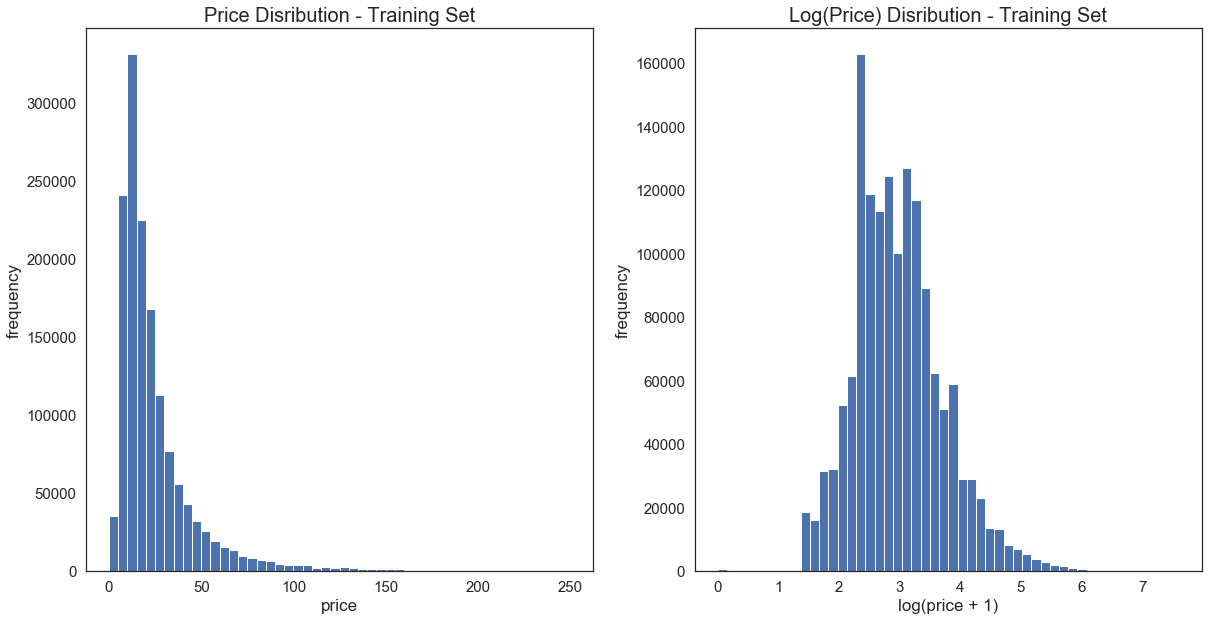

In [7]:
for i in range(2):
    plt.subplot(1, 2, i + 1)
    if i == 0:
        (train['price']).plot.hist(bins=50, figsize=(20, 10), edgecolor='white', range=[0, 250])
    else:
        np.log(train['price'] + 1).plot.hist(bins=50, figsize=(20, 10), edgecolor='white')

    plt.xlabel('{}'.format('log(price + 1)' if i else 'price'), fontsize=17)
    plt.ylabel('frequency', fontsize=17)
    plt.tick_params(labelsize=15)
    plt.title('{} Disribution - Training Set'.format('Log(Price)' if i else 'Price'), fontsize=20)

In [8]:
# 0: by buyer, 1: by seller
train.shipping.value_counts() / len(train)

0    0.552726
1    0.447274
Name: shipping, dtype: float64

In [9]:
price_shipBySeller = train.loc[train.shipping == 1, 'price']
price_shipByBuyer = train.loc[train.shipping == 0, 'price']

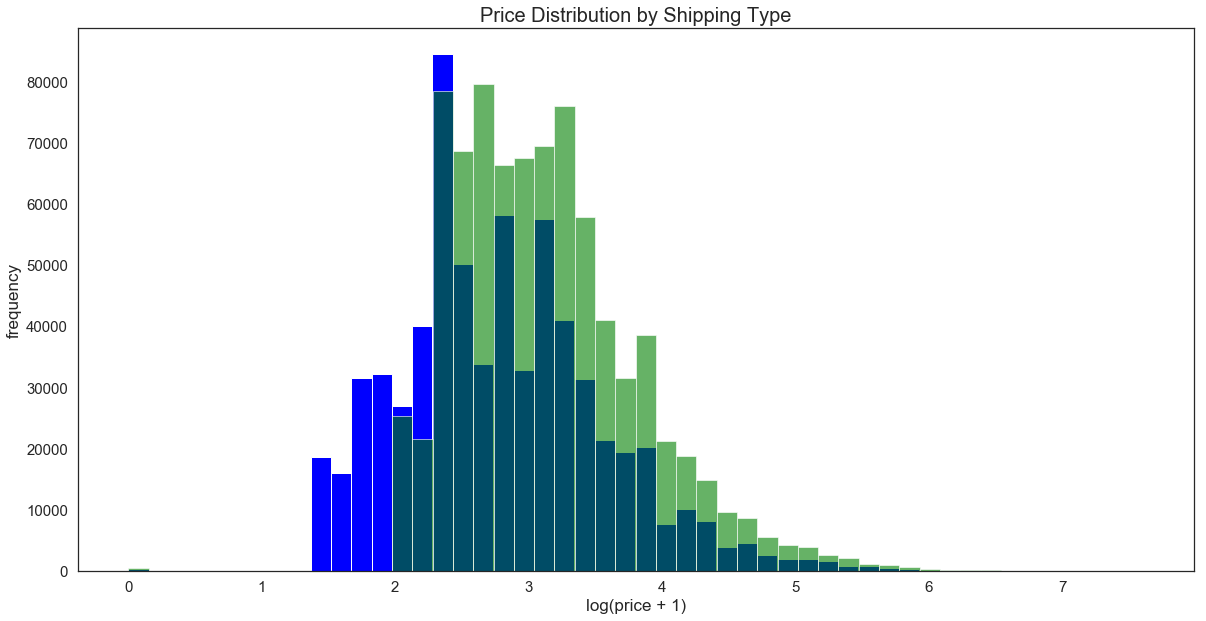

In [10]:
fix, ax = plt.subplots(figsize=(20, 10))
ax.hist(np.log(price_shipBySeller + 1), color='blue', alpha=1.0, bins=50, label='seller')
ax.hist(np.log(price_shipByBuyer + 1), color='green', alpha=0.6, bins=50, label='buyer')
plt.xlabel('log(price + 1)', fontsize=17)
plt.ylabel('frequency', fontsize=17)
plt.title('Price Distribution by Shipping Type', fontsize=20)
plt.tick_params(labelsize=15)
plt.show()

In [11]:
train['category_name'].nunique()

1287

In [12]:
def check_null_value(dataset):
    for i, s in enumerate(dataset.count()):
        if s != dataset.shape[0]:
            print('  Column "{}" has {} of NULL value'.format(dataset.columns[i], dataset.shape[0] - s))

In [13]:
check_null_value(train)
check_null_value(test)

  Column "category_name" has 6327 of NULL value
  Column "brand_name" has 632682 of NULL value
  Column "item_description" has 4 of NULL value
  Column "category_name" has 3058 of NULL value
  Column "brand_name" has 295525 of NULL value


In [14]:
train['category_name'].value_counts()[:5]

Women/Athletic Apparel/Pants, Tights, Leggings    60177
Women/Tops & Blouses/T-Shirts                     46380
Beauty/Makeup/Face                                34335
Beauty/Makeup/Lips                                29910
Electronics/Video Games & Consoles/Games          26557
Name: category_name, dtype: int64

In [15]:
def split_cat(text):
    try:
        return text.split('/')
    except:
        return ('No Label' for i in range(3))

In [16]:
full_data = [train, test]
for data in full_data:
    data['general_cat'], data['subcat_1'], data['subcat_2'] = zip(*data['category_name'].apply(split_cat))

In [17]:
train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,general_cat,subcat_1,subcat_2
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet,Men,Tops,T-shirts
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces


In [18]:
all_category = ['general_cat', 'subcat_1', 'subcat_2']
for category in all_category:
    print('{}: There are {} categories'.format(category, train[category].nunique()))

general_cat: There are 11 categories
subcat_1: There are 114 categories
subcat_2: There are 871 categories


In [19]:
for category in all_category:
    if train[category].nunique() >= 15:
        x = train[category].value_counts().index.values.astype('str')[:15]
        y = train[category].value_counts().values[:15]
    else:
        x = train[category].value_counts().index.values.astype('str')
        y = train[category].value_counts().values

    pct = ['{0:.2f}%'.format(v * 100) for v in (y / len(train))]
    trace1 = go.Bar(x=x, y=y, text=pct,
                   marker=dict(color=y, colorscale='Portland', showscale=True, reversescale=False))
    layout = dict(title='Number of Items by {} Category'.format(category),
                 yaxis=dict(title='Count'),
                 xaxis=dict(title='Category'))
    fig = dict(data=[trace1], layout=layout)
    py.iplot(fig)

In [20]:
train['brand_name'].nunique()

4809

In [21]:
x = train['brand_name'].value_counts().index.values.astype('str')[:15]
y = train['brand_name'].value_counts()[:15]
pct = ['{0:.2f}%'.format(v * 100) for v in (y / len(train))]

In [22]:
trace1 = go.Bar(x=x, y=y, text=pct,
               marker=dict(color=y, colorscale='Portland', showscale=True, reversescale=False))
layout = dict(title='Brand Name counts',
             yaxis=dict(title='Count'),
             xaxis=dict(title='Brand Name'))
fig = dict(data=[trace1], layout=layout)
py.iplot(fig)

In [23]:
def wordCount(text):
    try:
        text = text.lower()
        regex = re.compile('[{}0-9\\r\\t\\n]'.format(re.escape(string.punctuation)))
        txt = regex.sub(' ', text)
        words = [w for w in txt.split(' ') if not w in stop_words.ENGLISH_STOP_WORDS and len(w) > 3]
        return len(words)
    except:
        return 0

In [24]:
train['desc_len'] = train['item_description'].apply(wordCount)
test['desc_len'] = test['item_description'].apply(wordCount)

In [25]:
train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,general_cat,subcat_1,subcat_2,desc_len
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet,Men,Tops,T-shirts,1
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts,14
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse,8
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents,14
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces,3


In [26]:
df = train.groupby('desc_len')['price'].mean().reset_index()

In [27]:
df.head()

,desc_len,price
0,0,22.880522
1,1,22.623600
2,2,24.013826
3,3,24.021083
4,4,24.262873


In [28]:
trace1 = go.Scatter(x=df['desc_len'],
                   y=np.log(df['price'] + 1),
                   mode='lines+markers',
                   name='lines+markers')
layout = dict(title='Average Log(Price) by Description Length',
             yaxis=dict(title='Average Log(Price)'),
             xaxis=dict(title='Description Length'))
fig = dict(data=[trace1], layout=layout)
py.iplot(fig)

In [29]:
check_null_value(train)

  Column "category_name" has 6327 of NULL value
  Column "brand_name" has 632682 of NULL value
  Column "item_description" has 4 of NULL value


In [30]:
train = train[pd.notnull(train['item_description'])]

In [31]:
check_null_value(train)

  Column "category_name" has 6327 of NULL value
  Column "brand_name" has 632679 of NULL value


In [32]:
general_cats = train['general_cat'].unique()

In [33]:
train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,general_cat,subcat_1,subcat_2,desc_len
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet,Men,Tops,T-shirts,1
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts,14
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse,8
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents,14
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces,3


In [34]:
stop = set(stopwords.words('english'))
def tokenize(text):
    try:
        regex = re.compile('[{}0-9\\r\\t\\n]'.format(re.escape(string.punctuation)))
        text = regex.sub(' ', text)

        tokens = []
        for token_by_sent in [word_tokenize(s) for s in sent_tokenize(text)]:
            tokens += token_by_sent
        tokens = list(filter(lambda t: t.lower() not in stop, tokens))
        filtered_tokens = [w for w in tokens if re.search('[a-zA-Z]', w)]
        filtered_tokens = [w.lower() for w in filtered_tokens if len(w) >= 3]
        return filtered_tokens
    except TypeError as e:
        print(text, e)

In [35]:
cat_desc = dict()
for cat in general_cats:
    text = ' '.join(train.loc[train['general_cat'] == cat, 'item_description'].values)
    cat_desc[cat] = tokenize(text)

In [36]:
flat_lst = [item for sublist in list(cat_desc.values()) for item in sublist]
allWordCount = Counter(flat_lst)
all_top10 = allWordCount.most_common(20)
x = [w[0] for w in all_top10]
y = [w[1] for w in all_top10]

In [37]:
print(x, y)

['new', 'size', 'brand', 'free', 'condition', 'shipping', 'worn', 'used', 'never', 'black', 'great', 'price', 'color', 'pink', 'one', 'bundle', 'small', 'like', 'please', 'good'] [497274, 454428, 271187, 267335, 255450, 223943, 186959, 184055, 158825, 153001, 152960, 145056, 122849, 122691, 122058, 121560, 117408, 114447, 114075, 105459]


In [38]:
trace1 = go.Bar(x=x, y=y)
layout = dict(title='Word Frequency',
             yaxis=dict(title='Count'),
             xaxis=dict(title='Word'))
fig = dict(data=[trace1], layout=layout)
py.iplot(fig)

In [39]:
train['tokens'] = train['item_description'].map(tokenize)
test['tokens'] = test['item_description'].map(tokenize)

In [40]:
train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,general_cat,subcat_1,subcat_2,desc_len,tokens
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet,Men,Tops,T-shirts,1,"[description, yet]"
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts,14,"[keyboard, great, condition, works, like, came..."
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse,8,"[adorable, top, hint, lace, key, hole, back, p..."
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents,14,"[new, tags, leather, horses, retail, stand, fo..."
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces,3,"[complete, certificate, authenticity]"


In [46]:
from contextlib import contextmanager
import time

@contextmanager
def timer(name):
    t0 = time.time()
    yield
    print('"{}" done in {}'.format(name, time.time() - t0))

In [48]:
# timer usage
with timer('test'):
    for _ in range(100):
        pass

"test" done in 1.4066696166992188e-05


In [50]:
for description, tokens in zip(train['item_description'].head(), train['tokens'].head()):
    print('description: {}'.format(description))
    print('tokens: {}'.format(tokens))
    print()

description: No description yet
tokens: ['description', 'yet']

description: This keyboard is in great condition and works like it came out of the box. All of the ports are tested and work perfectly. The lights are customizable via the Razer Synapse app on your PC.
tokens: ['keyboard', 'great', 'condition', 'works', 'like', 'came', 'box', 'ports', 'tested', 'work', 'perfectly', 'lights', 'customizable', 'via', 'razer', 'synapse', 'app']

description: Adorable top with a hint of lace and a key hole in the back! The pale pink is a 1X, and I also have a 3X available in white!
tokens: ['adorable', 'top', 'hint', 'lace', 'key', 'hole', 'back', 'pale', 'pink', 'also', 'available', 'white']

description: New with tags. Leather horses. Retail for [rm] each. Stand about a foot high. They are being sold as a pair. Any questions please ask. Free shipping. Just got out of storage
tokens: ['new', 'tags', 'leather', 'horses', 'retail', 'stand', 'foot', 'high', 'sold', 'pair', 'questions', 'please', 

In [63]:
women100 = Counter(cat_desc['Women']).most_common(100)
beauty100 = Counter(cat_desc['Beauty']).most_common(100)
kids100 = Counter(cat_desc['Kids']).most_common(100)
electronics100 = Counter(cat_desc['Electronics']).most_common(100)

In [75]:
top100 = {'Women': {'toplists': women100, 'axis': [0, 0]},
          'Beauty': {'toplists': beauty100, 'axis': [0, 1]},
          'Kids': {'toplists': kids100, 'axis': [1, 0]},
          'Electronics': {'toplists': electronics100, 'axis': [1, 1]}}

In [76]:
for category in top100:
    print(category, top100[category]['axis'])

Kids [1, 0]
Beauty [0, 1]
Women [0, 0]
Electronics [1, 1]


In [64]:
def generate_wordcloud(tup):
    wordcloud = WordCloud(background_color='white',
                         max_words=50, max_font_size=40,
                         random_state=42).generate(str(tup))
    return wordcloud

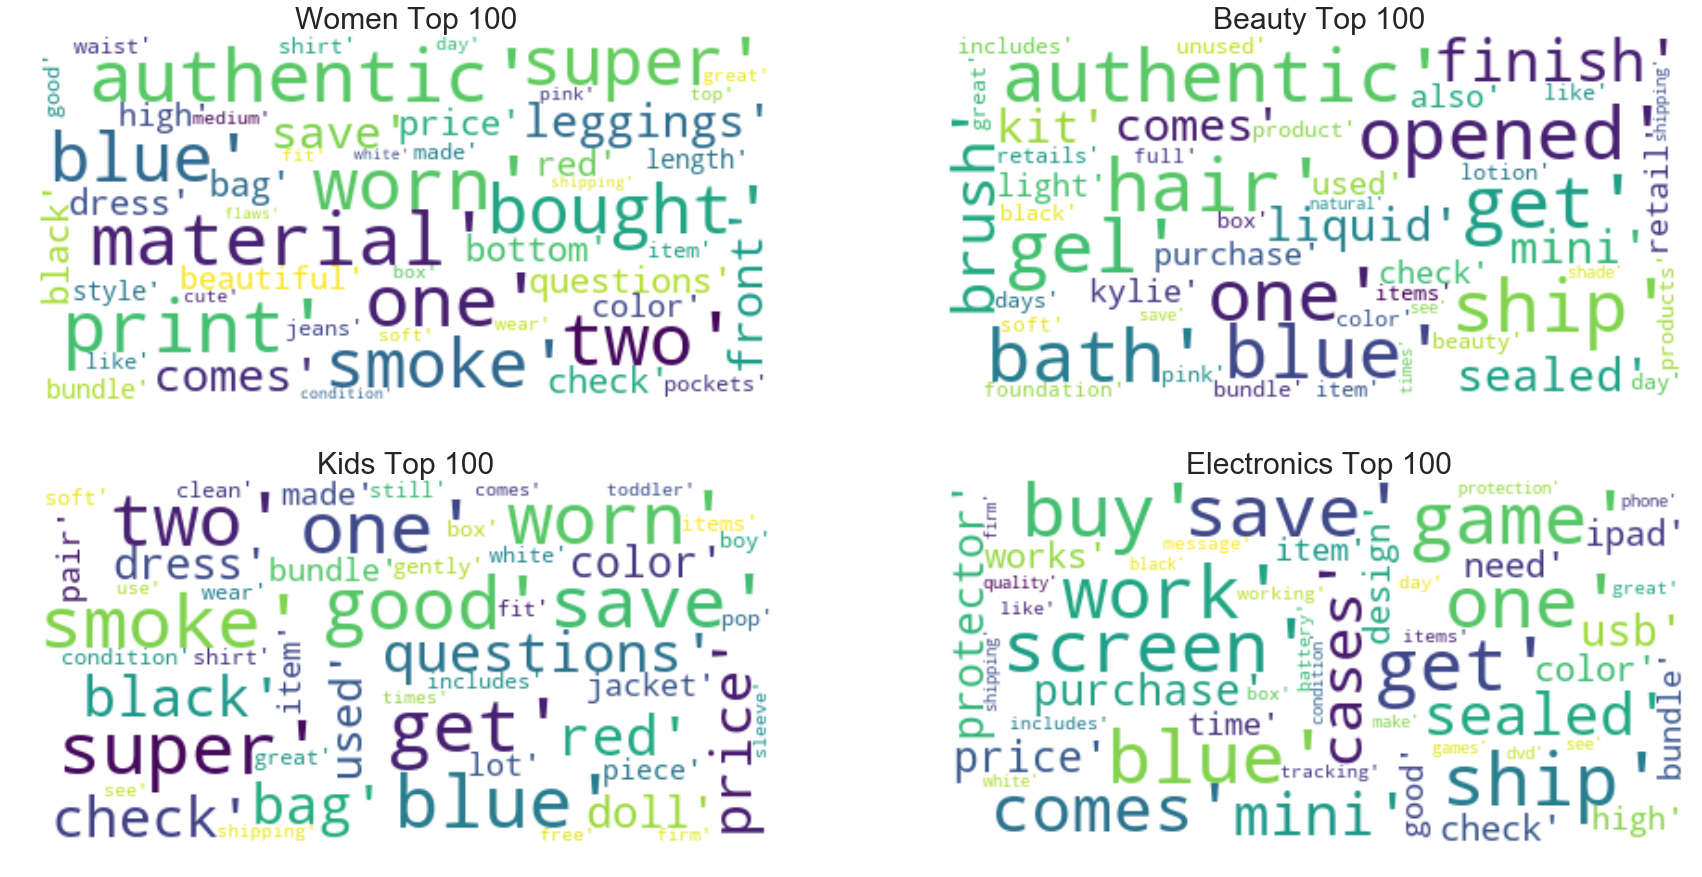

In [82]:
fig, axes = plt.subplots(2, 2, figsize=(30, 15))

for category in top100:
    toplists = top100[category]['toplists']
    axis1 = top100[category]['axis'][0]
    axis2 = top100[category]['axis'][1]
    ax = axes[axis1, axis2]
    ax.imshow(generate_wordcloud(toplists), interpolation='bilinear')
    ax.axis('off')
    ax.set_title('{} Top 100'.format(category), fontsize=30)